In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20,6)
rng = np.random.default_rng(51)

## Функции активации и их дифференциал

In [2]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

def dsigmoid(x):
  return sigmoid(x) * (1 - sigmoid(x))


def simpl_f(x):
  res = np.copy(x)
  res[res >= 0] = 1
  res[res < 0 ] = 0
  return res


def tanh(x):
  return np.tanh(x)

def dtanh(x):
  return 1 - np.square(tanh(x))

# Средняя квадратичная ошибка
def mse(y_pred, y):
  # 1/n*sum((угаданное-Y)^2)
  err = np.mean(np.square(y_pred - y))
  return err

# y_pred - рассчитанное значение, y - ожидаемое
def dmse(y_pred, y):
  n = y.shape[0]
  return (2/n)*(y_pred - y)

## Класс модели

In [106]:
class MLP:
  """ Классический многослойный персептрон"""
  def __init__(self, architecture, lr=0.01, is_need_f_final=False, fn=(sigmoid, dsigmoid)):
    self.depth = len(architecture) - 1
    self.lamda = lr
    # Требуется ли активационная функция на выходном слое
    self._is_need_func_final = is_need_f_final

    self.activation_fn = fn[0]
    self.activation_dfn = fn[1]

    self.error_fn = mse
    self.error_dfn = dmse

    # Веса (k, i, j - k: номер слоя 0 = первый скрытый слой; i - конкретный нейрон; j - нейрон предыдущего слоя)
    self.W = self._init_weights(architecture)
    # Смещение (или порог активации)
    # (k, i, j - k: номер слоя 0 = первый скрытый слой; i - конкретный нейрон; j=1)
    self.b = self._init_biases(architecture)


# Прямое направление
    # Сумматор
    self.z = [None] * (self.depth+1)
    # Результат функции активации (кроме последнего слоя) (k: номер слоя: 0 - вход, 1 - первый скрытый слой; j количество нейронов на слое; l - количество данных на батч
    self.a = [None] * (self.depth+1)

    #Дельта правило (при инициализации заполняются 0)
    self.dW = [np.zeros_like(w) for w in self.W]
    self.db = [np.zeros_like(b) for b in self.b]

    # glorot uniform init
  def _init_weights(self, arch):
    net_in = arch[0]
    net_out = arch[-1]
    limit = np.sqrt(6. / (net_in + net_out))
    return [rng.uniform(-limit, limit + 1e-5, size=(arch[i+1], arch[i])) for i in range(self.depth)]

  def _init_biases(self, arch):
    return [rng.random((arch[i+1],1))*2-1 for i in range(self.depth)]

  def set_weights(self, new_W):
    self.W = new_W

  def set_biases(self, new_b):
    self.b = new_b

  def compute_loss(self, X, y):
    # X[l][in]
    y_pred = self.predict(X).reshape(y.shape)
    return self.error_fn(y_pred, y)

  # Расчет прямого прохождения для нескольких X
  def _feedforward(self, X):
    # -1; X.shape[0] - количество значений в батче
    # W[0].shape[1] - количество входов = net_in
    self.a[0] = X.T.reshape(self.W[0].shape[1], -1)
    # рассчитываем скрытые и выходной слои
    for k in range(self.depth):
      # перемножаются W [i (текущий слой), j (предыдущий)] * a[j (количество нейронов), l (количество в батче)]
      self.z[k+1] = np.matmul(self.W[k], self.a[k]) + self.b[k]
      # Выполняется только для скрытых слоев либо если передан _is_need_func_final
      if k != self.depth-1 or self._is_need_func_final:
        self.a[k+1] = self.activation_fn(self.z[k+1])
      else:
        self.a[-1] = self.z[-1]

# Расчет локального градиента при обратном распространении ошибок
  def _backprop(self, y, batch_size=32):
    # TODO сделать delta для выходящего слоя при _is_need_func_final
    # a[j, l], y[l, in] -> y[in, l]
    delta = self.error_dfn(self.a[-1], y.T)
    if self._is_need_func_final:
      delta *= self.activation_dfn(self.z[-1])
    for k in range(self.depth-1, 0, -1):
      # Идем в обратном порядке. k - текущий слой, k+1 следующий. j - количество нейронов в текущем слое. i - количество нейронов в k+1 слое,
      # todo возможно требуется поменять на loss_dfn
      if k != self.depth-1:

      # f(z[i][l]) * (dot (W[j][i], delta[i][l]) получаем [j][l], так как для W[k].shape(i) = z[k].shape(j)
        delta = self.activation_dfn(self.z[k+1]) * np.matmul(self.W[k+1].T, delta)
      # dot(delta[j][l], a[l][j]) должны получить dW[i, j]
      self.dW[k] = np.matmul(delta, self.a[k].T)
      # delta[j][1] sum l
      self.db[k] = np.sum(delta, axis=1, keepdims=True)

  # simple sgd
  def _update_params(self, lr=1e-2):
    for k in range(self.depth):
      self.W[k] -= lr*self.dW[k]
      self.b[k] -= lr*self.db[k]

  def train(self, X, y, lr=None, epochs=50, batch_size=32):
    """
    Обучение модели.

    -------
    :param X: Размерности l * in, где l количество входящих данных, in - количество входов
    :param y: Размерности l * out.
    :param lr:  learning rate, по умолчанию берет значение из MLP.lamda
    :param epochs: Количество эпох, по умолчанию 50.
    :param batch_size: Количество данных в одном батче. По умолчанию 32.
    :return: Возвращает вектор loss по эпохам
    """
    # n = y.shape[0]
    lr = lr if lr is not None else self.lamda

    epoch_losses = np.array([])
    dataset = list(zip(X, y))
    get_X = lambda z: z[0]
    get_y = lambda z: z[1]
    for i in range(epochs):
      rng.shuffle(dataset)

      X_batch = np.array([get_X(x) for x in dataset])
      y_batch = np.array([get_y(y) for y in dataset])
      # for (X_batch, y_batch) in get_batches(dataset, batch_size):
      self._feedforward(X_batch)# X_batch)
      self._backprop(y_batch)# y_batch)
      self._update_params(lr=lr)

      epoch_losses = np.append(epoch_losses, self.compute_loss(X, y))
    return epoch_losses

  def predict(self, X):
    """
    Предсказать значение на уже обученной модели.

    ------
    :param X:На вход X размерности l * out, где l - количество полученных данных, out - количество выходящих нейронов.
    :return: Возвращает a размерности l * out
    """
    a = X.T.reshape(self.W[0].shape[1], -1)
    # compute hidden and output layers
    for i in range(self.depth):
      a = np.matmul(self.W[i], a) + self.b[i]
      if i != self.depth-1 or self._is_need_func_final:
        a = self.activation_fn(a)
    return a

## Используем модель

In [94]:
X_train = np.array([
    [-1, -1, -1],
    [-1, -1, 1],
    [-1, 1, -1],
    [-1, 1, 1],
    [1, -1, -1],
    [1, -1, 1],
    [1, 1, -1],
    [1, 1, 1]
])
y_train = np.array([[-1, 1, -1, 1, -1, 1, -1, -1]]).T

In [95]:
X_train, y_train

(array([[-1, -1, -1],
        [-1, -1,  1],
        [-1,  1, -1],
        [-1,  1,  1],
        [ 1, -1, -1],
        [ 1, -1,  1],
        [ 1,  1, -1],
        [ 1,  1,  1]]),
 array([[-1],
        [ 1],
        [-1],
        [ 1],
        [-1],
        [ 1],
        [-1],
        [-1]]))

In [108]:
net_arch_test = (3, 6, 1)
mlp_test = MLP(net_arch_test, fn=(tanh, dtanh), is_need_f_final=True)

In [109]:
loss_epoches = mlp_test.train(X_train, y_train, epochs=500, lr=0.05)

In [110]:
i = [0, 1, 2, 3]
res = mlp_test.predict(X_train).T
print('Входящие данные\n',X_train, y_train)
print('Результат:\n',res)
print('Разница между результатом и y_train:\n', abs(res-y_train))
print('Loss\n', mlp_test.compute_loss(X_train, y_train))

Входящие данные
 [[-1 -1 -1]
 [-1 -1  1]
 [-1  1 -1]
 [-1  1  1]
 [ 1 -1 -1]
 [ 1 -1  1]
 [ 1  1 -1]
 [ 1  1  1]] [[-1]
 [ 1]
 [-1]
 [ 1]
 [-1]
 [ 1]
 [-1]
 [-1]]
Результат:
 [[-0.95276112]
 [ 0.99953105]
 [-0.98361675]
 [ 0.9419663 ]
 [-0.99976936]
 [ 0.92962511]
 [-0.9999727 ]
 [-0.91883295]]
Разница между результатом и y_train:
 [[4.72388769e-02]
 [4.68945240e-04]
 [1.63832542e-02]
 [5.80336994e-02]
 [2.30638844e-04]
 [7.03748933e-02]
 [2.72975891e-05]
 [8.11670458e-02]]
Loss
 0.0021761026948780484


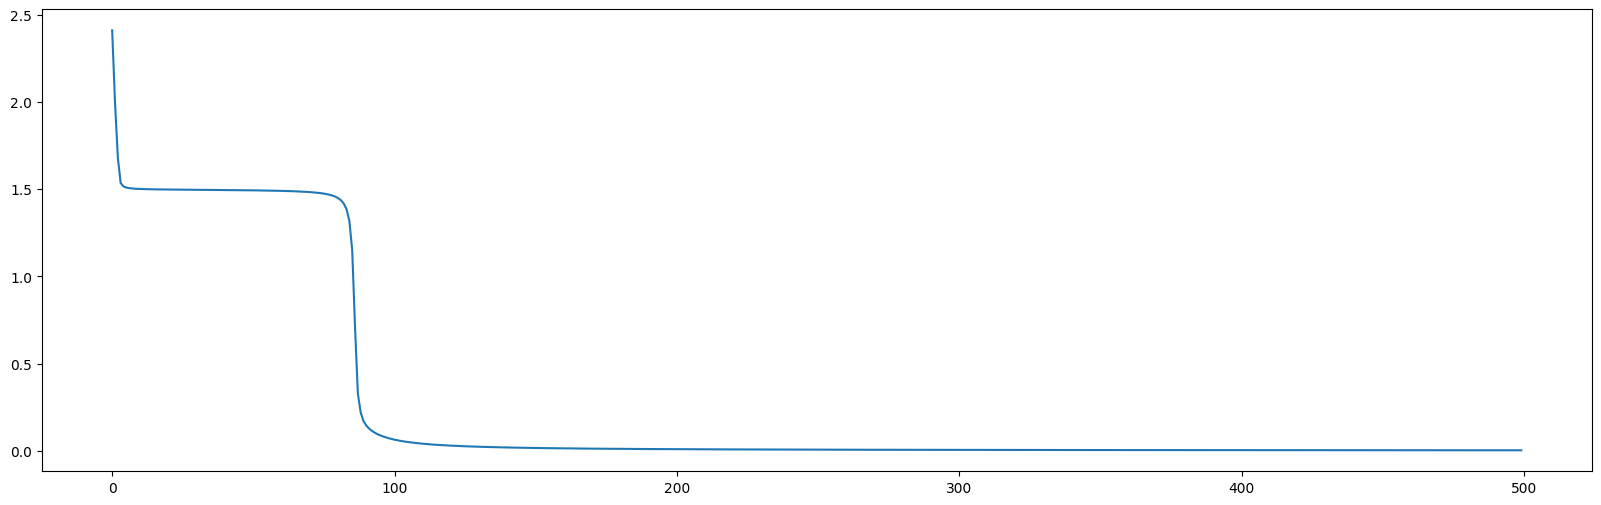

In [111]:
plt.plot(loss_epoches)

TODO проверить транспонирование и индексы

In [37]:
X_train2 = np.array([-1, 0, 1]).reshape(-1,1)
y_train2 = np.array([0, -1, 1]).reshape(-1,1)
net_arch_test2 = (1, 3, 1)
mlp_test2 = MLP(net_arch_test2, fn=(tanh, dtanh))
mlp_test2.W

[array([[ 0.41156718],
        [-1.49674125],
        [ 1.69103268]]),
 array([[ 1.7048934 ,  0.58596701, -0.59567012]])]

In [38]:
mlp_test2.train(X_train2, y_train2, epochs=1000)

In [39]:
mlp_test2.z[1].shape

(3, 3)

In [40]:
mlp_test2.predict(X_train2)

array([[-0.00242615, -0.99616654,  0.99736798]])